In [87]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 글꼴 경로 설정 (예: Malgun Gothic)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 경우
font_prop = fm.FontProperties(fname=font_path, size=12)

# Matplotlib의 기본 글꼴 설정
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 표시 설정

# 2030 Data with surv-anlyze columns
- 생존기간
- 2023년 12월 기준 생존 여부 

In [88]:
tmp = pl.scan_csv('data/CUSTOMER_SCORE_금리.csv')
#tmp_1= pl.scan_csv('data/output_2030.csv')
#tmp_2 = pl.scan_csv()

In [89]:
tmp.collect_schema().names()

['고객ID',
 '기준년월',
 '연령대',
 '성별',
 '고객등급',
 '입출금예금',
 '기타예금',
 '비이자상품',
 '카드',
 '대출',
 '기준금리',
 '보유상품수',
 '거래기간(개월)',
 '총점수']

In [90]:
tmp = tmp.filter([
    (pl.col('연령대') == 20) |
    (pl.col('연령대') == 30) 
])


In [91]:
# 생존 여부 칼럼 생성성

tmp = tmp.with_columns([
    # 마지막 기준년월(202312)에 존재하면 0, 아니면 1
    (pl.col('기준년월').max().over('고객ID') != 202312) \
        .cast(pl.Int8) \
        .alias('surv')
])

In [92]:
'''
tmp = tmp.group_by('고객ID').agg(
    [
        pl.col('surv').last().alias('surv'),
        pl.col('거래기간(개월)').last().alias('surv_periods'),
        (pl.col('입출금예금').last() - pl.col('입출금예금').first()).alias('account_range'),
        (pl.col('기타예금').last() - pl.col('기타예금').first()).alias('etc_account_range'),
        (pl.col('비이자상품').last() - pl.col('비이자상품').first()).alias('nonint_range'),
        (pl.col('카드').last() - pl.col('카드').first()).alias('card_range'),
        (pl.col('대출').last() - pl.col('대출').first()).alias('loan_range'),
        (pl.col('보유상품수').last() - pl.col('보유상품수').first()).alias('items_range'),
        (pl.col('총점수')).mean().alias('totalscore_mean'),
    ]
)
'''

"\ntmp = tmp.group_by('고객ID').agg(\n    [\n        pl.col('surv').last().alias('surv'),\n        pl.col('거래기간(개월)').last().alias('surv_periods'),\n        (pl.col('입출금예금').last() - pl.col('입출금예금').first()).alias('account_range'),\n        (pl.col('기타예금').last() - pl.col('기타예금').first()).alias('etc_account_range'),\n        (pl.col('비이자상품').last() - pl.col('비이자상품').first()).alias('nonint_range'),\n        (pl.col('카드').last() - pl.col('카드').first()).alias('card_range'),\n        (pl.col('대출').last() - pl.col('대출').first()).alias('loan_range'),\n        (pl.col('보유상품수').last() - pl.col('보유상품수').first()).alias('items_range'),\n        (pl.col('총점수')).mean().alias('totalscore_mean'),\n    ]\n)\n"

In [93]:
tmp = tmp.group_by('고객ID').agg(
    [
        pl.col('surv').last().alias('surv'),
        pl.col('거래기간(개월)').last().alias('surv_periods'),
        (pl.col('입출금예금')).mean().alias('account_'),
        (pl.col('기타예금')).mean().alias('etc_account_mean'),
        (pl.col('비이자상품').last() - pl.col('비이자상품').first()).alias('nonint_mean'),
        (pl.col('카드')).mean().alias('card_mean'),
        (pl.col('대출')).mean().alias('loan_mean'),
        (pl.col('보유상품수')).mean().alias('items_mean'),
        (pl.col('보유상품수')).max().alias('items_max'),
        (pl.col('총점수')).mean().alias('totalscore_mean'),
    ]
)

In [94]:
surv_data = tmp.collect()
surv_data

고객ID,surv,surv_periods,account_,etc_account_mean,nonint_mean,card_mean,loan_mean,items_mean,items_max,totalscore_mean
i64,i8,i64,f64,f64,i64,f64,f64,f64,i64,f64
4864657300,0,31,0.0,1.8981e7,0,0.0,0.0,1.0,1,795.419355
3192408108,0,31,54838.709677,0.0,0,0.0,2e6,1.451613,2,881.709677
4465543976,0,31,406451.612903,0.0,0,56774.193548,0.0,1.16129,2,63.688172
6537396741,1,20,3.3e6,0.0,0,0.0,0.0,1.0,1,280.633333
5382539920,0,31,1.3710e6,0.0,0,200000.0,0.0,1.516129,2,168.709677
…,…,…,…,…,…,…,…,…,…,…
4924101632,0,31,4.5258e6,0.0,0,0.0,0.0,1.0,1,381.44086
4420492829,0,31,100000.0,0.0,0,410000.0,0.0,2.0,2,127.8
7176570070,1,11,672727.272727,0.0,0,1.3382e6,0.0,1.909091,2,315.751515


# 생존 EDA

In [95]:
surv_data['surv'].value_counts() # 1이 이탈

surv,count
i8,u32
0,588175
1,88994


In [96]:
surv_data['surv_periods'].value_counts(sort=True)

surv_periods,count
i64,u32
31,464050
1,9881
3,9831
2,9809
7,9445
…,…
23,4557
24,4532
25,4482


# kaplan - meier 생존곡선

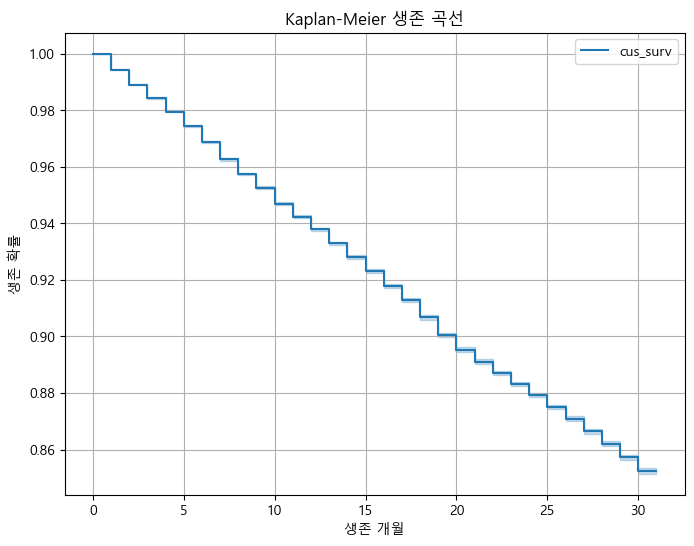

In [97]:
from lifelines import KaplanMeierFitter

# Kaplan-Meier Fitter 모델 생성
kmf = KaplanMeierFitter()

# 전체 데이터에 대한 생존 함수 그리기
plt.figure(figsize=(8, 6))
kmf.fit(durations=surv_data['surv_periods'], event_observed=surv_data['surv'], label = 'cus_surv')
kmf.plot_survival_function()

plt.title("Kaplan-Meier 생존 곡선")
plt.xlabel("생존 개월")
plt.ylabel("생존 확률")
plt.grid()
plt.show()

(88994, 11) (588175, 11)


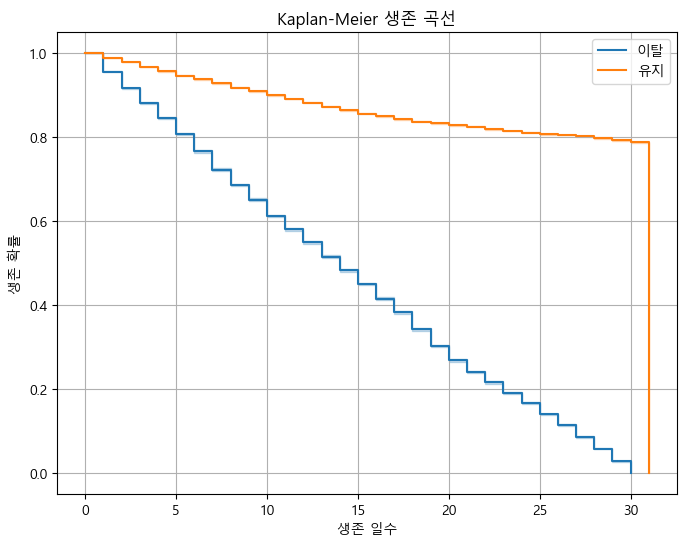

In [98]:
# 폐지된 그룹과 아닌 그룹의 케플란-마이어 결과
tmp_closed = surv_data.filter(pl.col('surv') == 1)  # 이탈한 사용자 분석
tmp_suv = surv_data.filter(pl.col('surv') == 0)     # 잔류한 이용자 분석

print(tmp_closed.shape, tmp_suv.shape)


# 전체 데이터에 대한 생존 함수 그리기
plt.figure(figsize=(8, 6))

kmf.fit(durations=tmp_closed['surv_periods'], label = '이탈')
kmf.plot_survival_function()

kmf.fit(durations=tmp_suv['surv_periods'], label = '유지')
kmf.plot_survival_function()

plt.title("Kaplan-Meier 생존 곡선")
plt.xlabel("생존 일수")
plt.ylabel("생존 확률")
plt.grid()
plt.show()

# Cox 비례위험모델


## 비례위험 확인 

ValueError: Could not interpret value `account_range` for `y`. An entry with this name does not appear in `data`.

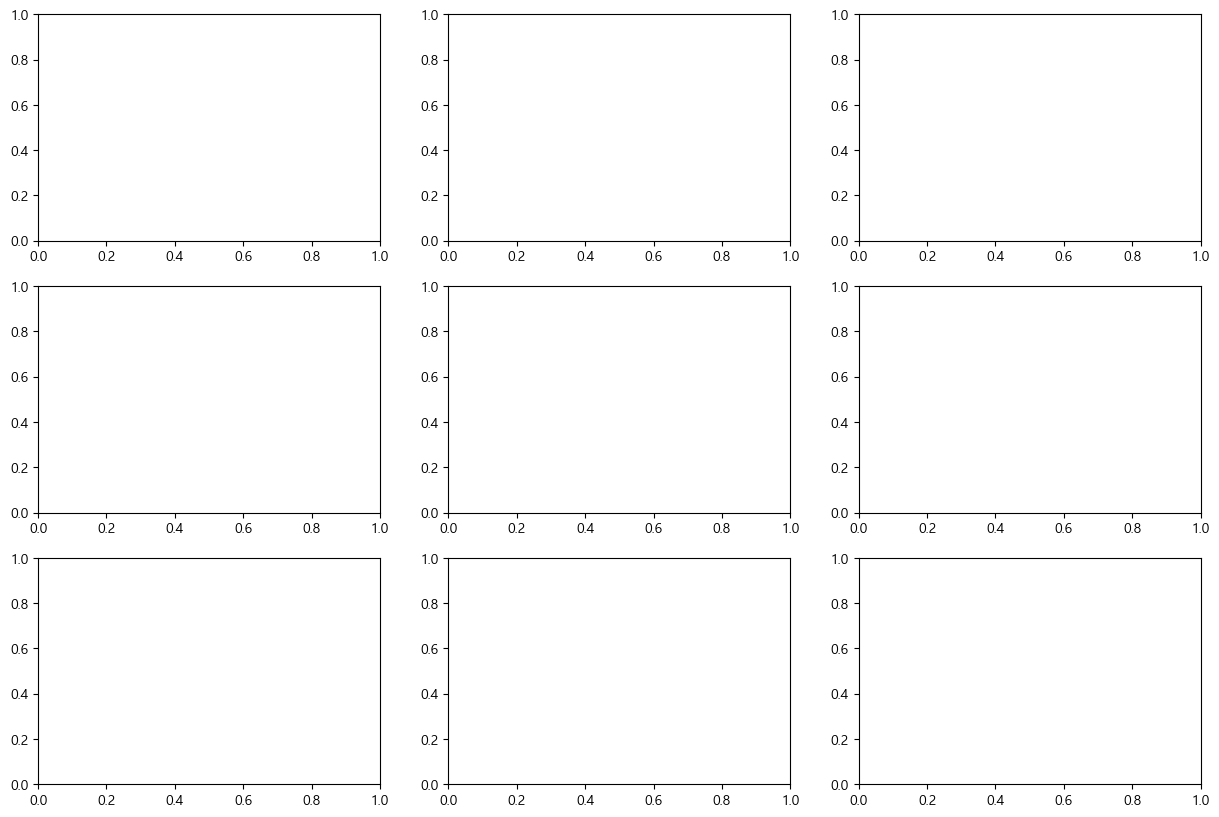

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Polars DataFrame을 pandas로 변환
surv_data_pd = surv_data.to_pandas()

# 1. 박스플롯 그리기
# 수치형 변수 선택
numeric_columns = ['account_range', 'etc_account_range', 'nonint_range', 
                  'card_range', 'loan_range', 'items_range' ,'totalscore_mean']

# 서브플롯 설정
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()  # 2D array를 1D로 변환

# 각 변수별 박스플롯
for idx, col in enumerate(numeric_columns):
    sns.boxplot(data=surv_data_pd, y=col, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {col}')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


다중공선성 체크 (VIF):
VIF > 10인 경우 다중공선성이 있다고 판단
--------------------------------------------------
            Variable       VIF
4         loan_range  1.150481
5        items_range  1.145946
6    totalscore_mean  1.093662
3         card_range  1.054987
1  etc_account_range  1.028267
0      account_range  1.015502
2       nonint_range  1.000590


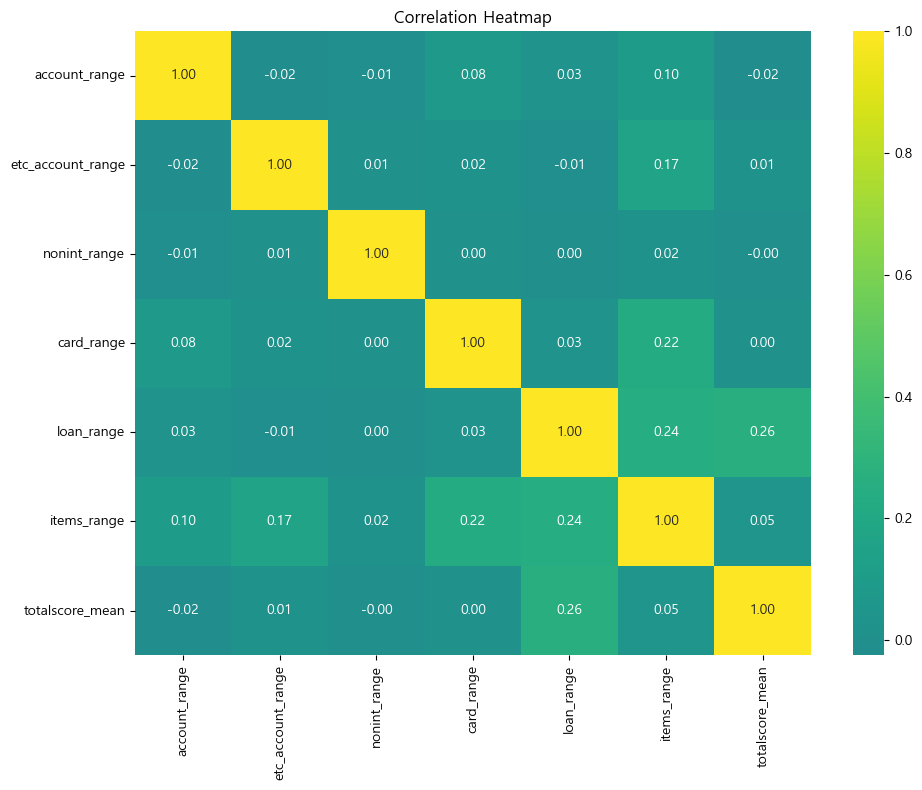


기초 통계량:
--------------------------------------------------
       account_range  etc_account_range  nonint_range    card_range  \
count   6.771690e+05       6.771690e+05  6.771690e+05  6.771690e+05   
mean   -6.965086e+04       6.464410e+05 -6.693602e+03  4.965644e+03   
std     5.871447e+06       6.531175e+06  9.510399e+05  4.064434e+05   
min    -1.120000e+08      -1.720000e+08 -9.600000e+07 -2.262000e+07   
25%    -1.000000e+05       0.000000e+00  0.000000e+00  0.000000e+00   
50%     0.000000e+00       0.000000e+00  0.000000e+00  0.000000e+00   
75%     1.000000e+05       0.000000e+00  0.000000e+00  0.000000e+00   
max     1.210000e+08       1.480000e+08  9.540000e+07  3.095000e+07   

         loan_range    items_range  totalscore_mean  
count  6.771690e+05  677169.000000    677169.000000  
mean   9.962771e+05      -0.154374       974.597498  
std    1.121641e+07       0.916749      2991.136053  
min   -9.900000e+07      -5.000000         0.000000  
25%    0.000000e+00      -1.00

In [81]:
# 2. 다중공선성 체크 (VIF)
# 수치형 변수들의 VIF 계산
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i)
                       for i in range(df[features].shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

# VIF 계산 및 출력
print("\n다중공선성 체크 (VIF):")
print("VIF > 10인 경우 다중공선성이 있다고 판단")
print("-" * 50)
vif_result = calculate_vif(surv_data_pd, numeric_columns)
print(vif_result)

# 3. 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(surv_data_pd[numeric_columns].corr(), 
            annot=True,  # 상관계수 표시
            cmap='viridis',  # 색상맵
            center=0,  # 중앙값 (0) 기준
            fmt='.2f')  # 소수점 2자리까지 표시
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# 4. 기초 통계량 출력
print("\n기초 통계량:")
print("-" * 50)
print(surv_data_pd[numeric_columns].describe())

## Cox 분석 

<lifelines.CoxPHFitter: fitted with 677169 total observations, 588175 right-censored observations>
             duration col = 'surv_periods'
                event col = 'surv'
      baseline estimation = breslow
   number of observations = 677169
number of events observed = 88994
   partial log-likelihood = -1166248.98
         time fit was run = 2025-03-12 08:38:55 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
account_range      0.00      1.00      0.00            0.00            0.00                1.00                1.00
etc_account_range -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
nonint_range       0.00      1.00      0.00           -0.00            0.00                1.00                1.00
card_range         0.00      1.00      0.00           -0.00            0.00                1.00                1.00
loan_range         0.00      1.00      0.00            0.00            0.00                1.00                1.00
items_range        0.09      1.10      0.00            0.09            0.10                1.09                1.11
totalscore_mean    0.00      1.00      0.00            0.00            0.00                1.00                1.00

                   cmp to      z      p  -log2(p)
covariate                                        
account_range        0.00   7.82 <0.005     47.44
etc_account_range    0.00 -16.41 <0.005    198.51
nonint_range         0.00   0.54   0.59      0.76
card_range           0.00   0.38   0.71      0.50
loan_range           0.00  93.98 <0.005       inf
items_range          0.00  24.28 <0.005    430.24
totalscore_mean      0.00  78.04 <0.005       inf
---
Concordance = 0.61
Partial AIC = 2332511.97
log-likelihood ratio test = 23558.42 on 7 df
-log2(p) of ll-ratio test = inf

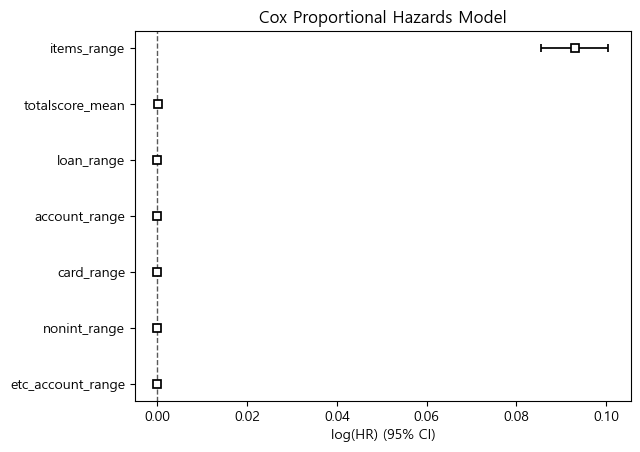

In [82]:
from lifelines import CoxPHFitter

# Polars DataFrame을 pandas DataFrame으로 변환
surv_data_pd = surv_data.to_pandas()

# Cox Proportional Hazards 모델 생성
cph = CoxPHFitter()

# 모델 학습
# Polars DataFrame을 pandas DataFrame으로 변환한 데이터 사용
cph.fit(surv_data_pd.drop(columns=['고객ID']), 
        duration_col='surv_periods', 
        event_col='surv')

# 모델 요약 출력
cph.print_summary()

# 생존 곡선 시각화
cph.plot()
plt.title("Cox Proportional Hazards Model")
plt.show()

<lifelines.CoxPHFitter: fitted with 677169 total observations, 588175 right-censored observations>
             duration col = 'surv_periods'
                event col = 'surv'
      baseline estimation = breslow
   number of observations = 677169
number of events observed = 88994
   partial log-likelihood = -1166543.06
         time fit was run = 2025-03-12 08:38:59 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
account_range      0.00      1.00      0.00            0.00            0.00                1.00                1.00
etc_account_range -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
nonint_range       0.00      1.00      0.00           -0.00            0.00                1.00                1.00
card_range         0.00      1.00      0.00            0.00            0.00                1.00                1.00
loan_range         0.00      1.00      0.00            0.00            0.00                1.00                1.00
totalscore_mean    0.00      1.00      0.00            0.00            0.00                1.00                1.00

                   cmp to      z      p  -log2(p)
covariate                                        
account_range        0.00   9.85 <0.005     73.57
etc_account_range    0.00 -12.29 <0.005    112.91
nonint_range         0.00   1.15   0.25      2.01
card_range           0.00   5.81 <0.005     27.23
loan_range           0.00 106.93 <0.005       inf
totalscore_mean      0.00  76.59 <0.005       inf
---
Concordance = 0.61
Partial AIC = 2333098.13
log-likelihood ratio test = 22970.26 on 6 df
-log2(p) of ll-ratio test = inf

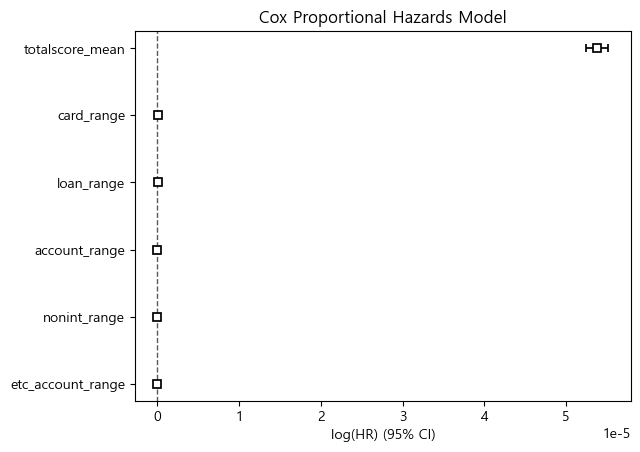

In [83]:
from lifelines import CoxPHFitter

# Polars DataFrame을 pandas DataFrame으로 변환
surv_data_tmp = surv_data_pd.drop(columns=['고객ID', 'items_range'])

# 모델 학습
# Polars DataFrame을 pandas DataFrame으로 변환한 데이터 사용
cph.fit(surv_data_tmp, 
        duration_col='surv_periods', 
        event_col='surv')

# 모델 요약 출력
cph.print_summary()

# 생존 곡선 시각화
cph.plot()
plt.title("Cox Proportional Hazards Model")
plt.show()

In [84]:
surv_data_pd

,고객ID,surv,surv_periods,account_range,etc_account_range,nonint_range,card_range,loan_range,items_range,totalscore_mean
0,2366654398,0,9,0,0,0,0,400000,0,661.092593
1,3385327724,0,31,-100000,0,0,0,0,0,32.623656
2,4094846943,0,31,0,0,0,0,0,0,18.000000
3,5031089222,1,8,200000,0,0,-140000,0,0,212.108333
4,3829546295,0,31,300000,0,0,110000,0,2,107.843011
...,...,...,...,...,...,...,...,...,...,...
677164,9540396275,1,10,0,0,0,0,0,0,34.000000
677165,6216591044,0,31,200000,0,-600000,0,0,0,529.311828
677166,7549754733,1,25,43800000,-54200000,0,-230000,20000000,1,2930.782667
677167,4865058376,0,31,300000,0,0,0,0,0,43.913978


In [100]:
# 데이터로 저장
surv_data_pd.to_csv('data/surv_data_2030_mean.csv')